# Data Wrangling with Spark
This workspace contains a tiny subset (128MB) of the full dataset available (12GB) to explore a smaller subset with Spark before deploying your cluster on the cloud. The dataset describes log events comming from a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [1]:
!pip install --upgrade matplotlib

    100% |████████████████████████████████| 11.5MB 1.6MB/s eta 0:00:01  1% |▋                               | 215kB 18.1MB/s eta 0:00:01    6% |██▏                             | 778kB 9.8MB/s eta 0:00:02    17% |█████▌                          | 2.0MB 23.8MB/s eta 0:00:01    37% |████████████                    | 4.3MB 24.6MB/s eta 0:00:01    46% |███████████████                 | 5.4MB 22.0MB/s eta 0:00:01    51% |████████████████▍               | 5.9MB 9.3MB/s eta 0:00:01    56% |██████████████████              | 6.5MB 24.6MB/s eta 0:00:01    71% |██████████████████████▉         | 8.2MB 25.9MB/s eta 0:00:01    76% |████████████████████████▌       | 8.8MB 25.7MB/s eta 0:00:01    86% |███████████████████████████▋    | 9.9MB 12.9MB/s eta 0:00:01    90% |█████████████████████████████   | 10.5MB 12.2MB/s eta 0:00:01    95% |██████████████████████████████▌ | 11.0MB 11.9MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 9.5MB/s eta 0:00:01    39% |████████████▊              

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.types import*

from pyspark.ml import Pipeline, Transformer

import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Spark SQL").getOrCreate()

## Loading and Cleaning the Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# the IP address of the master node
path = "mini_sparkify_event_data.json"

In [5]:
# loading the json file into a spark DataFrame
user_log = spark.read.json(path)

### Data Exploration 

In [6]:
# Seeing the columns we have in this dataframe
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



There are fields describing the user like firstName, lastName and userId. We also have information about the request, for example, the page the user accessed, the HTTP method, and the status of the request.

In [8]:
# looking at one particular record
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

Here we can see that Colin was listening to "Rockpools"

In [9]:
# Looking at the first 5 records
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [10]:
# Summary statistics on the length column
user_log.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [11]:
print("We have {} rows on the dataset".format(user_log.count()))

We have 286500 rows on the dataset


In [12]:
# Looking at the page requests that we have
user_log.select("page").dropDuplicates().sort("page").show(25)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Users can login and out, visit the homepage, or play a song.

In [13]:
user_log.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



We have two subscriptions levels, and we are going to define that a user chured when the changed from paid to free user

In [14]:
user_log.select("auth").dropDuplicates().sort("auth").show() 

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [15]:
# Looking at the events of userId 30
user_log.select(["userId", "firstName", "page", "song"]).filter(user_log.userId == "30").head(10)

[Row(userId='30', firstName='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstName='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstName='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstName='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Here I Am')]

As users use different pages of the application, their page request are logged

### Dropping Rows with Missing Values
Dropping missing values, making sure that we have the userId and SessionId for all the records

In [16]:
# Dropping missing values
user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])

In [17]:
# Making sure that we have the userId and SessionId for all the records
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



There are not None values but there are users with no userId

In [18]:
# Looking at logs of users with no userId
user_log.select(["userId", "firstName", "page", "song"]).filter(user_log.userId == "").head(10)

[Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Help', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None)]

In [19]:
# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

blank_pages.collect()

[Row(blank_pages='Home'),
 Row(blank_pages='About'),
 Row(blank_pages='Submit Registration'),
 Row(blank_pages='Login'),
 Row(blank_pages='Register'),
 Row(blank_pages='Help'),
 Row(blank_pages='Error')]

It seems that the user's with no id represent users who have not signed up yet or who are signed out and are about to log in.
It may also represents users who got an error while registrating or loging in.

In [20]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [21]:
user_log_valid.count()

278154

We lost 8346 records. 

In [22]:
print("We lost {} records".format(user_log.count() - user_log_valid.count()))

We lost 8346 records


In [23]:
female_users = user_log_valid.filter(user_log_valid.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

male_users = user_log_valid.filter(user_log_valid.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

In [24]:
print("We have {} female users and {} male users".format(female_users, male_users))

We have 104 female users and 121 male users


How many songs were played from the most played artist?

In [25]:
user_log_valid.filter(user_log_valid.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+-------------+-----------+
|       Artist|Artistcount|
+-------------+-----------+
|Kings Of Leon|       1841|
+-------------+-----------+
only showing top 1 row



## Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Defining Churn as Users Who Cancel Their Accounts
Both paid and free users can Cancel their accounts. I will use this as the label for the model

To distinguish user's activity before and after they cancel their account, I create a Churn column which divides the users who have confirm a cancellation to use as the label of the model.

In [26]:
# Adding a new column called Churn_phase to the dataframe
# The value here will be 1 if the user cancelled, and zero other wise
# # create churn user column

flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("Churn_phase", flag_churn_event("page"))

In [27]:
# Sorting records for a particular user in reverse time order, and adding up the values to distinguish each user's data 
# as either pre or post churn events
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# Creating a Churn_phase column that uses the window function and cumulative sum
user_log_valid = user_log_valid.withColumn('Churn', Fsum('Churn_phase').over(windowval))

In [28]:
# Checking the results
user_log_valid.filter("page = 'Cancellation Confirmation'").count() == user_log_valid.select('userId') \
    .where(user_log_valid.Churn == 1).dropDuplicates().count()

True

In [29]:
user_log_valid.select(["userId", "firstname", "ts", "page", "Churn", "Churn_phase"]) \
    .filter(user_log_valid.userId == "18").sort(desc("ts")).head(5)

[Row(userId='18', firstname='Adriel', ts=1538943990000, page='Cancellation Confirmation', Churn=1, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538943740000, page='Cancel', Churn=1, Churn_phase=0),
 Row(userId='18', firstname='Adriel', ts=1538943739000, page='Downgrade', Churn=1, Churn_phase=0),
 Row(userId='18', firstname='Adriel', ts=1538943726000, page='NextSong', Churn=1, Churn_phase=0),
 Row(userId='18', firstname='Adriel', ts=1538943440000, page='NextSong', Churn=1, Churn_phase=0)]

After the Cancellation Confirmation we no longer see logs from user Adriel

In [30]:
user_log_valid.groupBy('Churn').count().show()

+-----+------+
|Churn| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



In [31]:
user_log_valid.groupBy('Churn_phase').count().show()

+-----------+------+
|Churn_phase| count|
+-----------+------+
|          1|    52|
|          0|278102|
+-----------+------+



In [32]:
seed = 42

fractions_train = user_log_valid.select("Churn").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
train_user_log = user_log_valid.stat.sampleBy("Churn", fractions_train, seed)

fractions_test = user_log_valid.select("Churn").distinct().withColumn("fraction", lit(0.2)).rdd.collectAsMap()
test_user_log = user_log_valid.stat.sampleBy("Churn", fractions_test, seed)

In [33]:
train = train_user_log.alias('train')

## Exploring Data to observe the behavior for users who stayed vs users who churned. 

### Exploring aggregates on these two groups of users

In [34]:
## Plot in a histogram the distinct artist that are listened by churn users and not churn users
artist_per_user = train.filter(train.Churn == 0).groupby(train.userId, train.artist) \
    .count()
artist_per_user_pd = artist_per_user.toPandas()
artist_per_user_pd = artist_per_user_pd[~artist_per_user_pd['artist'].isnull()]
artist_per_user_pd = artist_per_user_pd.groupby('userId').count().drop("count", axis=1)

In [35]:
## Plot in a histogram the distinct artist that are listened by churn users and not churn users
artist_per_user_churn = train.filter(train.Churn == 1) \
    .groupby(train.userId, train.artist).count()
artist_per_user_churn_pd = artist_per_user_churn.toPandas()
artist_per_user_churn_pd = artist_per_user_churn_pd[~artist_per_user_churn_pd['artist'].isnull()]
artist_per_user_churn_pd = artist_per_user_churn_pd.groupby('userId').count().drop("count", axis=1)

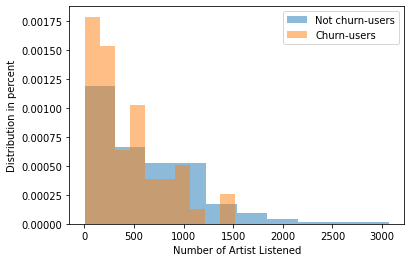

In [36]:
plt.hist(artist_per_user_pd["artist"], density=True, label="Not churn-users", alpha=0.5);
plt.hist(artist_per_user_churn_pd["artist"], density=True, label="Churn-users", alpha=0.5);
plt.xlabel("Number of Artist Listened");
plt.ylabel("Distribution in percent");
plt.legend();

We can notice from this graph that Not churn-users tend to listen to a higher number of artists compared to churn-users

In [37]:
# Avg of each page visited
page_percent = train.filter(train.Churn == 0).groupBy('page').count() \
    .withColumn('Percent', col('count')/sum('count').over(Window.partitionBy())).select(["page", "Percent"])
page_percent = page_percent.orderBy('Percent', ascending=False)
page_percent = page_percent.toPandas()

page_percent_churn = train.filter(train.Churn == 1).groupBy('page').count() \
    .withColumn('Percent_Churn_Users', col('count')/sum('count').over(Window.partitionBy())) \
    .select(["page", "Percent_Churn_Users"])
page_percent_churn = page_percent_churn.orderBy('Percent_Churn_Users', ascending=False)
page_percent_churn = page_percent_churn.toPandas()

In [38]:
page_percent_comparison = page_percent.merge(page_percent_churn, on='page')
page_percent_comparison['Diff'] = (page_percent_comparison['Percent'] - page_percent_comparison['Percent_Churn_Users']) \
    .abs()
page_percent_comparison.sort_values('Diff', ascending=False)

,page,Percent,Percent_Churn_Users,Diff
0,NextSong,0.821775,0.811945,0.009830
5,Roll Advert,0.012537,0.021370,0.008833
1,Thumbs Up,0.045912,0.041148,0.004764
7,Thumbs Down,0.008832,0.011258,0.002425
4,Add Friend,0.015465,0.014498,0.000967
6,Logout,0.011402,0.012263,0.000862
12,Upgrade,0.001670,0.002486,0.000816
3,Add to Playlist,0.023633,0.023046,0.000587
9,Settings,0.005358,0.005922,0.000564
11,About,0.001847,0.001285,0.000562


### Calculating Statistics by Hour

#### Observing how much of a specific action they experienced per a certain time unit

In [39]:
# Converting timestamps to datetime from epoch time, to get the hour of the day
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
# Adding a new column called hour to our dataframe
train = train.withColumn("hour", get_hour(train.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
train = train.withColumn("day", get_day(train.ts))

get_weekday = udf(lambda ts: datetime.datetime.fromtimestamp(ts/1000), TimestampType())
train = train.withColumn("weekday", dayofweek(get_weekday(train.ts)))

get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
train = train.withColumn("month", get_month(train.ts))

train.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn_phase=0, Churn=0, hour='18', day='21', weekday=4, month='11')

Colin was listening to Martha Tilston at 12am

In [40]:
items_per_day_churn_oct = train.filter((train.Churn == 1) & (train.month == 10)) \
    .select("userId", "day", "itemInSession").sort("userId", "day", "itemInSession").groupBy("userId", "day") \
    .count().sort("userId", "day").toPandas()
items_per_day_oct = train.filter((train.Churn == 0) & (train.month == 10)) \
    .select("userId", "day", "itemInSession").sort("userId", "day", "itemInSession").groupBy("userId", "day") \
    .count().sort("userId", "day").toPandas()
items_per_day_all_oct = items_per_day_oct['count'].to_frame() \
    .join(items_per_day_churn_oct['count'], lsuffix=' Not Churn', rsuffix=' Churn')

items_per_day_churn_nov = train.filter((train.Churn == 1) & (train.month == 11)) \
    .select("userId", "day", "itemInSession").sort("userId", "day", "itemInSession").groupBy("userId", "day") \
    .count().sort("userId", "day").toPandas()
items_per_day_nov = train.filter((train.Churn == 0) & (train.month == 10)) \
    .select("userId", "day", "itemInSession").sort("userId", "day", "itemInSession").groupBy("userId", "day") \
    .count().sort("userId", "day").toPandas()
items_per_day_all_nov = items_per_day_nov['count'].to_frame() \
    .join(items_per_day_churn_nov['count'], lsuffix=' Not Churn', rsuffix=' Churn')

In [41]:
items_per_day_all_oct.rename(columns={'count Not Churn': 'Not Churn', 'count Churn': 'Churn'}, inplace=True)
items_per_day_all_nov.rename(columns={'count Not Churn': 'Not Churn', 'count Churn': 'Churn'}, inplace=True)

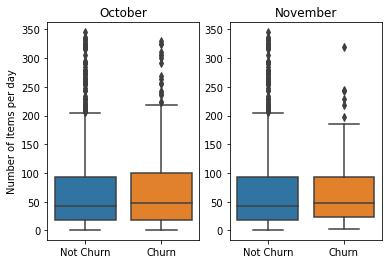

In [42]:
import seaborn as sns
plt.subplot(1, 2, 1)
plt.title('October')
sns.boxplot(data=items_per_day_all_oct);
plt.ylabel("Number of Items per day");
plt.subplot(1, 2, 2)
plt.title('November')
sns.boxplot(data=items_per_day_all_nov);

In [43]:
# Counting the Ads
ads_in_weekday = train.filter((train.page == "Roll Advert") & (train.Churn == 0)) \
    .groupby(train.weekday).count().orderBy(train.weekday.cast("float"))
ads_in_weekday_pd = ads_in_weekday.toPandas()

In [44]:
# Counting the Ads
ads_in_weekday_churn = train.filter((train.page == "Roll Advert") & (train.Churn == 1)) \
    .groupby(train.weekday).count().orderBy(train.weekday.cast("float"))
ads_in_weekday_churn_pd = ads_in_weekday_churn.toPandas()

In [45]:
ads_in_weekday_pd['count'] = ads_in_weekday_pd['count']/train.filter(train.Churn==0).count()

In [46]:
ads_in_weekday_churn_pd['count'] = ads_in_weekday_churn_pd['count']/train.filter(train.Churn==1).count()

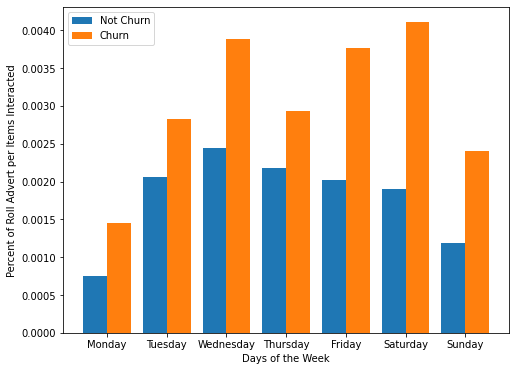

In [47]:
import numpy as np
X = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'] 
X_axis = np.arange(7)

plt.figure(figsize=(8, 6))
plt.bar(X_axis - 0.2, ads_in_weekday_pd['count'], 0.4, label = 'Not Churn')
plt.bar(X_axis + 0.2, ads_in_weekday_churn_pd['count'], 0.4, label = 'Churn')
  
plt.xticks(X_axis, X)
plt.xlabel("Days of the Week")
plt.ylabel("Percent of Roll Advert per Items Interacted")
plt.legend()
plt.show()

In [48]:
thumbs_table = train.filter((train.page == 'Thumbs Down') | (train.page == 'Thumbs Up')) \
    .select("page", "Churn")
thumbs_table = thumbs_table.toPandas()

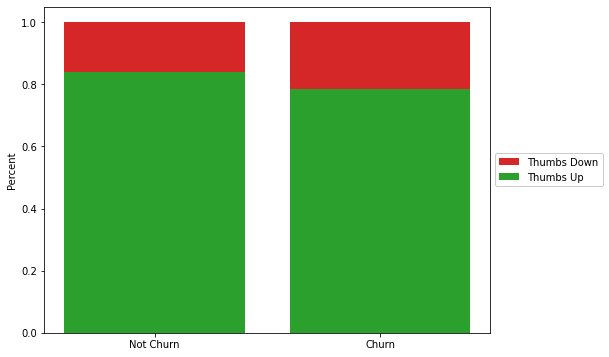

In [49]:
user = [0, 1]
thumbs = ['Thumbs Up', 'Thumbs Down']
colors = ['C2', 'C3']

artists = [] # for storing references to plot elements
baselines = np.zeros(len(user))
user_counts = thumbs_table['Churn'].value_counts()

plt.figure(figsize=(8, 6))
# for each second-variable category:
for i, color in zip(range(len(thumbs)), colors):
    # isolate the counts of the first category,
    thumb = thumbs[i]
    inner_counts = thumbs_table[thumbs_table['page'] == thumb]['Churn'].value_counts()
    inner_props = inner_counts / user_counts
    # then plot those counts on top of the accumulated baseline
    bars = plt.bar(x = np.arange(len(user)),
                   height = inner_props[user],
                   bottom = baselines, 
                   color=color)
    artists.append(bars)
    baselines += inner_props[user]

plt.xticks(np.arange(len(user)), ['Not Churn', 'Churn'])
plt.legend(reversed(artists), reversed(thumbs), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6);
plt.ylabel("Percent");

#### How many songs do users listen to in a given hour?

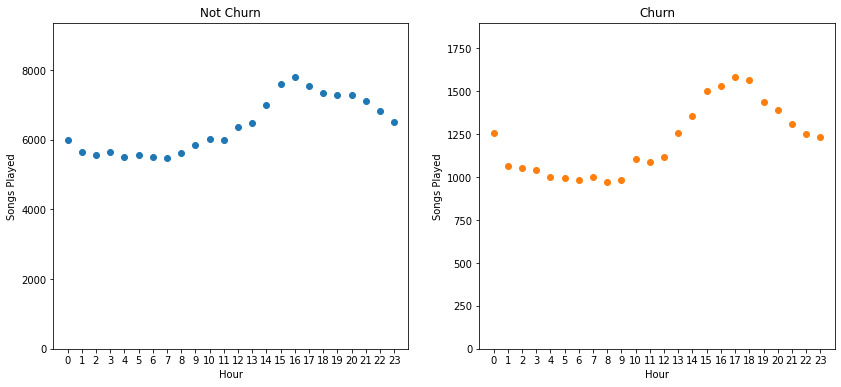

In [50]:
plt.figure(figsize=(14, 6))

# Counting the next song page requests
songs_in_hour = train.filter((train.page == "NextSong") & (train.Churn == 0)) \
    .groupby(train.hour).count().orderBy(train.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()

plt.subplot(1, 2, 1)
plt.title('Not Churn')
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * songs_in_hour_pd["count"].max())
plt.xlabel("Hour")
plt.ylabel("Songs Played");

# Counting the next song page requests
songs_in_hour_churn = train.filter((train.page == "NextSong") & (train.Churn == 1)) \
    .groupby(train.hour).count().orderBy(train.hour.cast("float"))
songs_in_hour_churn_pd = songs_in_hour_churn.toPandas()

plt.subplot(1, 2, 2)
plt.title('Churn')
plt.scatter(songs_in_hour_churn_pd["hour"], songs_in_hour_churn_pd["count"], color='C1')
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * songs_in_hour_churn_pd["count"].max())
plt.xlabel("Hour")
plt.ylabel("Songs Played");

We can see some trends in how many songs our users played in different hours of the day

In [51]:
n_songs = train.filter((train.Churn == 0) & (train.page == "NextSong")).count()
n_sessions = train.filter(train.Churn == 0).groupBy("userId", "sessionId").count().count()
n_songs_churn = train.filter((train.Churn == 1) & (train.page == "NextSong")).count()
n_sessions_churn = train.filter(train.Churn == 1).groupBy("userId", "sessionId").count().count()

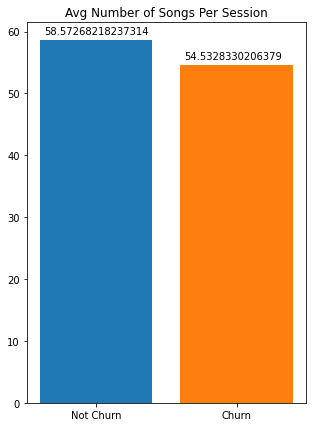

In [52]:
plt.figure(figsize=(5, 7));
plt.title('Avg Number of Songs Per Session');
plt.bar(x=['Not Churn', 'Churn'], height=[n_songs/n_sessions, n_songs_churn/n_sessions_churn], color=['C0', 'C1']);

values = [n_songs/n_sessions, n_songs_churn/n_sessions_churn]

for index, value in enumerate(values):
    plt.text(index-0.37, value+1, str(value))

In [53]:
# How many songs do notChurn users listen to on average between visiting our home page? 
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = train.filter((train.page == 'NextSong') | (train.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

df = cusum.filter((cusum.page == 'NextSong')) \
    .filter(train.Churn == 0) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).toPandas()
avg_songs_between_homepage = df.loc[0, 'avg(count(period))']

df_churn = cusum.filter((cusum.page == 'NextSong')) \
    .filter(train.Churn == 1) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).toPandas()
avg_songs_between_homepage_churn = df_churn.loc[0, 'avg(count(period))']

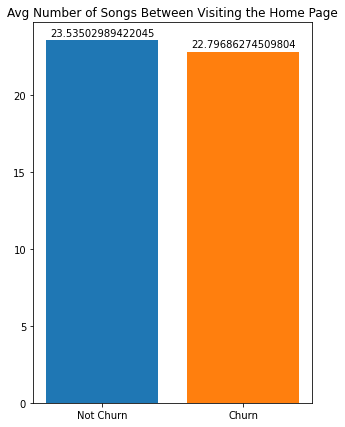

In [54]:
plt.figure(figsize=(5, 7));
plt.title('Avg Number of Songs Between Visiting the Home Page');
plt.bar(x=['Not Churn', 'Churn'], height=[avg_songs_between_homepage, avg_songs_between_homepage_churn], color=['C0', 'C1']);

values = [avg_songs_between_homepage, avg_songs_between_homepage_churn]

for index, value in enumerate(values):
    plt.text(index-0.37, value+0.3, str(value))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [55]:
# artist: count number of unique artist
# gender: 
# itemInSession: total number

# length: mean, std, min, 25, 50, 75, max
# level: count free, count paid
# registration:
# sessionId: total number of unique sessionIds
## ts: CALCULATE STATS WITH OTHER VARIABLES
    # count of unique ts
    # avg songs per day of the week 
    # avg ads per day of the week
# page: value_counts of each page except for cancel and cancel_confi
# userAgent: value counts MAYBE

In [56]:
train.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn_phase=0, Churn=0, hour='18', day='21', weekday=4, month='11')

In [98]:
df = train.groupBy("userId", "artist").count().groupBy("userId").count().withColumnRenamed("count", "n_artists")
df.show()

+------+---------+
|userId|n_artists|
+------+---------+
|100010|      215|
|200002|      269|
|   125|        8|
|   124|     1920|
|    51|     1187|
|     7|      114|
|    15|     1087|
|    54|     1467|
|   155|      539|
|100014|      191|
|   132|     1086|
|   154|       65|
|   101|     1049|
|    11|      421|
|   138|     1136|
|300017|     1778|
|100021|      178|
|    29|     1515|
|    69|      719|
|   112|      164|
+------+---------+
only showing top 20 rows



In [99]:
gender = train.select("userId", "gender").dropDuplicates()
gender.show()

+------+------+
|userId|gender|
+------+------+
|100010|     F|
|200002|     M|
|   125|     M|
|   124|     F|
|    51|     M|
|     7|     M|
|    15|     M|
|    54|     F|
|   155|     F|
|100014|     M|
|   132|     F|
|   154|     F|
|   101|     M|
|    11|     F|
|   138|     M|
|300017|     F|
|100021|     M|
|    29|     M|
|    69|     F|
|   112|     M|
+------+------+
only showing top 20 rows



In [101]:
train.select("userId").groupBy("userId").count().withColumnRenamed("count", "n_items").show()

+------+-------+
|userId|n_items|
+------+-------+
|100010|    318|
|200002|    373|
|   125|      9|
|   124|   3875|
|    51|   2000|
|     7|    158|
|    15|   1839|
|    54|   2723|
|   155|    805|
|100014|    246|
|   132|   1833|
|   154|     92|
|   101|   1689|
|    11|    652|
|   138|   1978|
|300017|   3548|
|100021|    267|
|    29|   2905|
|    69|   1080|
|   112|    238|
+------+-------+
only showing top 20 rows



In [60]:
train.filter(train.userId == 100010).select("userId", "length").dropna(how="any", subset=["length"]).show()

+------+---------+
|userId|   length|
+------+---------+
|100010|319.42485|
|100010|302.57587|
|100010|305.05751|
|100010|207.64689|
|100010|264.93342|
|100010|  227.082|
|100010| 281.5473|
|100010|367.15057|
|100010|299.75465|
|100010|258.16771|
|100010|260.25751|
|100010|237.47873|
|100010| 61.85751|
|100010|228.46649|
|100010| 320.1824|
|100010|181.21098|
|100010|248.58077|
|100010|321.54077|
|100010|175.56853|
|100010| 217.3122|
+------+---------+
only showing top 20 rows



In [89]:
# mean, std, min, 25, 50, 75, max
train.filter(train.userId == 100010).select("length").dropna(how="any", subset=["length"]).describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|              234|
|   mean|240.2018280769232|
| stddev| 78.0767004621482|
|    min|         52.27057|
|    max|        538.85342|
+-------+-----------------+



In [ ]:
class ColumnDropper(Transformer):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, banned_list: Iterable[str]):
        super(ColumnDropper, self).__init__()
        self.banned_list = banned_list

    def _transform(self, df: DataFrame) -> DataFrame:
        df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        return df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.